In [1]:
import numpy as np
import pandas as pd
import nose.tools as nt
import seaborn as sns
import matplotlib.pyplot as plt

from selectinf.base import (full_targets,
                     selected_targets,
                     debiased_targets)

from selectinf.randomized.group_lasso_query import (group_lasso,
                                                    split_group_lasso)

# Data Cleaning

In [2]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [3]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [4]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [5]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [135]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [7]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [8]:
data_X = data_X.to_numpy()

In [9]:
np.linalg.matrix_rank(data_X)

47

In [10]:
data_X.shape

(5985, 47)

In [11]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [12]:
np.linalg.matrix_rank(design_X)

48

In [13]:
design_X.shape

(5985, 48)

In [14]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [15]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [16]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [17]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [18]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [19]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [20]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [131]:
X_standardized[:,5:10]

array([[-0.0054,  0.0103,  0.    ,  0.    ,  0.0266],
       [-0.0054, -0.0053,  0.    ,  0.    ,  0.    ],
       [-0.0029,  0.0125,  0.    ,  0.    ,  0.0266],
       ...,
       [-0.0054, -0.0053,  0.0411,  0.    ,  0.    ],
       [ 0.0072, -0.0053,  0.    ,  0.    ,  0.    ],
       [-0.0054, -0.0053,  0.    ,  0.    ,  0.    ]])

In [132]:
design_X[:,5:10]

array([[0., 7., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 8., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [5., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [133]:
data_X

array([[36.  ,  0.83, 21.9 , ...,  0.  ,  0.  ,  0.  ],
       [68.  ,  1.2 , 30.2 , ...,  0.  ,  0.  ,  0.  ],
       [76.  ,  3.61, 26.6 , ...,  0.  ,  1.  ,  0.  ],
       ...,
       [67.  ,  2.19, 37.9 , ...,  0.  ,  0.  ,  0.  ],
       [40.  ,  3.82, 38.2 , ...,  0.  ,  0.  ,  0.  ],
       [63.  ,  3.71, 25.5 , ...,  1.  ,  0.  ,  0.  ]])

# Results

In [107]:
def plot_single_confidence_interval(x, point_est, interval,
                                    color='#2187bb', horizontal_line_width=0.25):

    left = x - horizontal_line_width / 2
    top = interval[0]
    right = x + horizontal_line_width / 2
    bottom = interval[1]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, point_est, 'o', color='#f44336')

def plot_full_CIs(point_ests, intervals, col_names, nonzero, title):
    col_names = np.array(col_names)
    E_card = len(col_names[nonzero])
    selected_col_names = col_names[nonzero]
    plt.xticks(list(range(1, E_card+1)), selected_col_names)
    plt.title(title)
    for j in range(E_card):
        plot_single_confidence_interval(j+1, point_est=point_ests[j],
                                        interval=intervals[j])
    plt.show()


In [108]:
Y = data_raw["depressed"]
sigma_ = np.std(Y)
weight_frac = 0.5
sigma_ = 1
weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
weights[0] = 0

In [109]:
conv = split_group_lasso.logistic(X=X_standardized,
                                      successes=Y,
                                      trials=np.ones(n),
                                      groups=groups,
                                      weights=weights,
                                      useJacobian=True,
                                      proportion=0.67)
signs, soln = conv.fit()
nonzero = signs != 0

In [110]:
conv.setup_inference(dispersion=1)

target_spec = selected_targets(conv.loglike,
                               conv.observed_soln,
                               dispersion=1)

result = conv.inference(target_spec,
                        method='selective_MLE',
                        level=0.9)
MLestimates = result['MLE']
pval = result['pvalue']
intervals = np.asarray(result[['lower_confidence',
                               'upper_confidence']])

In [111]:
MLestimates

0    -55.625006
1    -13.613727
2      5.688702
3    -22.563499
4     -6.479456
5     10.563761
6     18.200202
7     -4.453836
8    -10.223751
9    -15.424190
10    -6.854862
11    -7.911918
12     0.855124
13     2.980522
14    -7.802193
15    -5.727150
16    -5.297450
17   -28.943553
18   -46.940831
19   -46.610632
20   -32.507688
21   -29.969075
22    47.070498
23     8.983657
24    10.862761
Name: MLE, dtype: float64

In [112]:
nonzero

array([ True, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True, False,  True, False, False,  True,
        True, False, False])

In [104]:
nonzero.sum()

13

In [126]:
pval

0     1.131064e-01
1     9.951017e-02
2     6.209183e-02
3     4.495662e-03
4     3.898026e-01
5     2.563447e-01
6     1.538645e-02
7     6.607603e-01
8     1.417178e-01
9     3.661082e-02
10    4.039600e-01
11    3.282423e-01
12    9.163724e-01
13    7.448515e-01
14    3.224621e-01
15    4.801619e-01
16    5.360983e-01
17    5.735981e-04
18    2.776291e-05
19    2.706886e-04
20    7.700332e-03
21    3.570716e-06
22    1.443290e-14
23    1.711661e-01
24    1.697268e-03
Name: pvalue, dtype: float64

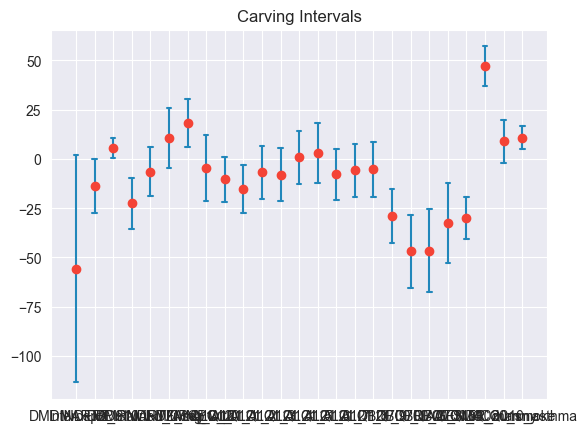

In [125]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals")

In [114]:
proportion = 0.67
conv_iso = group_lasso.logistic(X=X_standardized,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = X_standardized.T @ X_standardized * (1 - proportion) / proportion)
signs_iso, soln_iso = conv_iso.fit()
nonzero_iso = signs_iso != 0

In [115]:
conv_iso.setup_inference(dispersion=1)

target_spec_iso = selected_targets(conv_iso.loglike,
                               conv_iso.observed_soln,
                               dispersion=1)

result_iso = conv_iso.inference(target_spec_iso,
                        method='selective_MLE',
                        level=0.9)

pval_iso = result_iso['pvalue']
MLestimates_iso = result_iso['MLE']
intervals_iso = np.asarray(result_iso[['lower_confidence',
                               'upper_confidence']])

In [119]:
MLestimates_iso

0    -127.801525
1     -28.287078
2       2.323766
3      -0.937231
4       3.364805
5       5.288269
6       6.577906
7     -13.149823
8     -15.427738
9      -9.760618
10     -6.370961
11    -15.607071
12     -7.413924
13     -9.534162
14    -14.361279
15      0.011279
16    -11.825143
17    -28.228536
18    -45.453362
19    -45.887635
20    -25.085521
21     16.634235
22     13.806193
23      8.446619
24     14.421199
25      6.185495
Name: MLE, dtype: float64

In [116]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_iso))

[0.     0.     0.4999 0.8158 0.4461 0.2844 0.1819 0.0204 0.0001 0.0223
 0.1855 0.0009 0.1261 0.0771 0.0015 0.9981 0.0165 0.     0.     0.
 0.0003 0.     0.0002 0.0269 0.     0.0577]


In [117]:
nonzero_iso.sum()

26

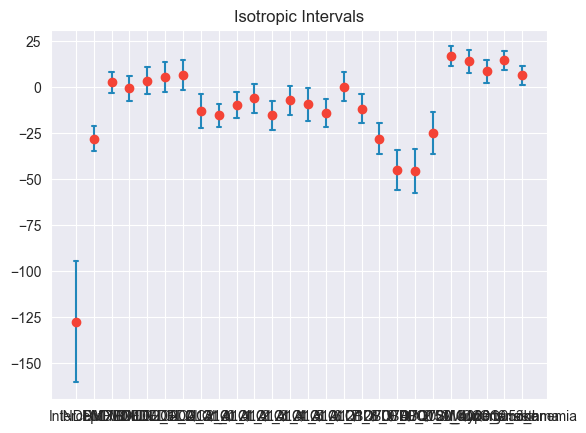

In [118]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic Intervals")

In [87]:
col_names

['Intercept',
 'RIDAGEYR',
 'INDFMPIR',
 'BMXBMI',
 'DBD895',
 'DBD905',
 'DBD910',
 'RIDRETH1_Mexican_American',
 'RIDRETH1_Other_Hispanic',
 'RIDRETH1_Non_Hispanic_White',
 'RIDRETH1_Non_Hispanic_Black',
 'DMDEDUC2_1',
 'DMDEDUC2_2',
 'DMDEDUC2_3',
 'DMDEDUC2_4',
 'DMDMARTZ_married_living_with',
 'DMDMARTZ_sep',
 'INDFMMPC_1',
 'INDFMMPC_2',
 'ALQ121_0',
 'ALQ121_1',
 'ALQ121_2',
 'ALQ121_3',
 'ALQ121_4',
 'ALQ121_5',
 'ALQ121_6',
 'ALQ121_7',
 'ALQ121_8',
 'ALQ121_9',
 'DBQ700_1',
 'DBQ700_2',
 'DBQ700_3',
 'DBQ700_4',
 'DBQ197_never',
 'DBQ197_rarely',
 'DBQ197_sometimes',
 'DBQ197_often',
 'DIQ010_diabetes',
 'DIQ010_diabetes_borderline',
 'RIAGENDR_man',
 'DMDBORN4_US',
 'ALQ151_dummy',
 'BPQ020_hypertension',
 'BPQ080_high_cholesterol',
 'SMQ020_smoke',
 'MCQ010_asthma',
 'MCQ053_anemia',
 'MCQ092_blood_transfusion']

In [122]:
col_names = np.array(col_names)
col_names[nonzero]

array(['Intercept', 'INDFMPIR', 'DBD910', 'DMDMARTZ_married_living_with',
       'DMDMARTZ_sep', 'INDFMMPC_1', 'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1',
       'ALQ121_2', 'ALQ121_3', 'ALQ121_4', 'ALQ121_5', 'ALQ121_6',
       'ALQ121_7', 'ALQ121_8', 'ALQ121_9', 'DBQ700_1', 'DBQ700_2',
       'DBQ700_3', 'DBQ700_4', 'RIAGENDR_man', 'ALQ151_dummy',
       'SMQ020_smoke', 'MCQ010_asthma'], dtype='<U28')

In [123]:
l = np.array([1,2,3,4,5,6,7])
bool = np.array([True, True, True, True, False, False, False])
l[bool]

array([1, 2, 3, 4])

In [124]:
np.sqrt(5985)

77.36278174936577